In [445]:
import cv2
import pytesseract
import pandas as pd
import numpy as np
import segyio
from segyio import TraceField ,BinField
import matplotlib.pyplot as plt
from segpy.dataset import Dataset
import logging
from pathlib import Path

import toml
from PIL import Image, ImageOps
from segpy.writer import write_segy

from img2segy.geometry import Geometry
from matrix_dataset import ImageDataset
from img2segy.trace_header_mapper import TraceHeaderMapper

logger = logging.getLogger(__name__)

# my=np.append(y[fromsample:],np.zeros(fromsample))
# len(trc),len(my)
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
%matplotlib inline

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def convert(image_filepath: Path, segy_filepath: Path=None, config_filepath: Path=None, *, force=False):
    image_filepath = Path(image_filepath)
    segy_filepath = (segy_filepath and Path(segy_filepath)) or image_filepath.with_suffix(".segy")
    config_filepath = (config_filepath and Path(config_filepath)) or image_filepath.with_suffix(".toml")

    logger.info("segy_filepath = %s", segy_filepath)
    logger.info("image_filepath = %s", image_filepath)
    logger.info("config_filepath = %s", config_filepath)
#     print(segy_filepath)
    return image_filepath,segy_filepath,config_filepath

pytesseract.pytesseract.tesseract_cmd ='C:\Program Files (x86)\Tesseract-OCR/tesseract.exe'

folder=r'C:\Users\ArunBabu\OneDrive - ANTELOPUS ENERGY PRIVATE LIMITED\Python\Digitization\Image2segy\\'
file='Seismic_data_to_be_digitized_bad_quality.png'
# file='Seismic_data_to_be_digitized_good_quality.png'
path=folder+file

image = cv2.imread(folder+file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# # cv2.drawContours(thresh, [c], -1, (0,0,0),ct_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
# cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     cv2.drawContours(thresh, [c], -1, (0,0,0), 3)

# # Remove vertical lines
# vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
# detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
# cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     cv2.drawContours(thresh, [c], -1, (0,0,0), 3)

# # cv2.imshow('thresh', thresh)
# cv2.imshow('thresh', gray)
# # cv2.imshow('result', result)
# # cv2.imshow('dilate', dilate)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

import numpy as np
from scipy import signal

#  For bad quality
strc=101
etrc=305
stime=0
etime=4900


# #  For good quality
# stime=-200
# etime=3100
# strc=2000
# etrc=2180


ntrc=(etrc-strc)*2.0


trange=np.arange(stime,etime+1,2).astype(int)
pixper_trc=thresh.shape[1]/ntrc

ntrc,thresh.shape,pixper_trc*ntrc,
pixrange=np.arange(0,thresh.shape[1]+1,pixper_trc).astype(int)
# pixrange
ntrc,trange

# 
thresh[thresh<100]=0
thresh[thresh>100]=1
# plt.hist(thresh)

traces=[]
for i in range(len(pixrange)-1):
#     print(pixrange[i],pixrange[i+1])
    trc=thresh[:,pixrange[i]:pixrange[i+1]].sum(axis=1)
    traces.append(trc)
pd.DataFrame(np.array(traces).T)

,0,1,2,3,4,5,6,7,8,9,...,398,399,400,401,402,403,404,405,406,407
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,2,0,1,0,0,0
1,0,1,1,2,1,0,0,1,0,2,...,0,0,1,2,0,0,1,0,0,0
2,0,0,0,2,0,0,0,0,0,2,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,0,0,0,0,0,1,0,1,0,0,...,1,1,1,1,2,1,2,0,0,0
578,0,0,0,1,0,1,0,1,1,1,...,1,1,2,1,2,1,2,0,0,0
579,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,0,1,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [88]:
# traces

In [343]:
# cv2.imshow('thresh', thresh)
cv2.imshow('gray', gray)
# cv2.imshow('result', result)
# cv2.imshow('dilate', dilate)
cv2.waitKey(0)
cv2.destroyAllWindows()

7

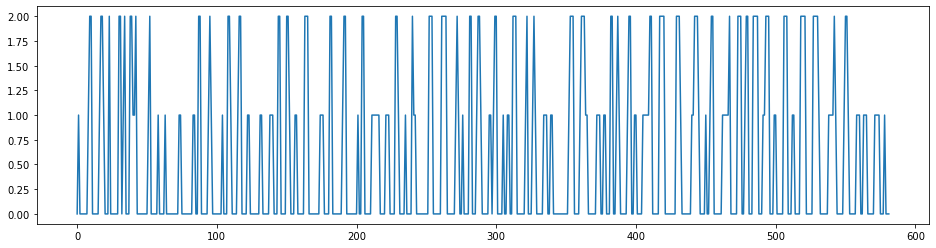

In [395]:
# plt.imshow( np.array(traces).T[:40,:20])
plt.figure(figsize=(16,4))
plt.plot(traces[10])
mtrc=traces[10].copy()
mtrc[mtrc>0]=10
dtrc=np.diff(mtrc.astype(float))
dtrc[dtrc>0]=1
dtrc[dtrc<0]=0
round(len(dtrc)/dtrc.sum())

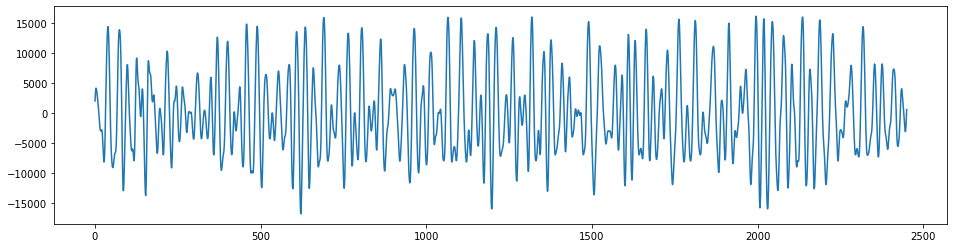

([<matplotlib.lines.Line2D at 0x1a6d55d7790>], 2451, 2451)

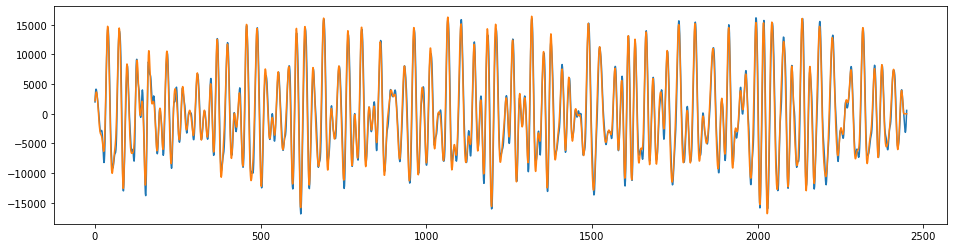

In [446]:
traces=(np.array(traces)*1000).astype(np.float64)
op=[-3,-1,2,4,2,-1,-3]

# op=[-5,-3,-1,2,3.5,7,3.5,2,-1,-3,-5]
# np.conv(traces[10],op)
proctrcs=[]
for trc in traces:
    res=np.convolve(trc,op)[3:len(trc)+3]
    f = signal.resample(res, len(trange))
    proctrcs.append(f)
plt.figure(figsize=(16,4))
plt.plot(proctrcs[10]),len(proctrcs[10]),len(proctrcs[10])
plt.show()
# res[:10],traces[10][:10]

# proctrcs=np.array(proctrcs).T
# proctrcs.shape

# plt.figure(figsize=(16,4))
# plt.plot(f),len(f),len(res)



filttrcs=[]
order = 6
fs = 500.0       # sample rate, Hz
cutoff = 35.0  # desired cutoff frequency of the filter, Hz
freq=cutoff
smpls2shift=round(900*pow(freq,-1.274))
fromsample=smpls2shift
# Filter the data, and plot both the original and filtered signals.
for trc in proctrcs:
    y = butter_lowpass_filter(trc, cutoff, fs, order)
    filttrcs.append(np.append(y[fromsample:],np.zeros(fromsample)))
# fromsample=5
# plt.plot(t[:len(t)-fromsample], , 'g-', linewidth=2, label='filtered data')
plt.figure(figsize=(16,4))
plt.plot(proctrcs[10]),len(proctrcs[10]),len(proctrcs[10])
plt.plot(filttrcs[10]),len(filttrcs[10]),len(filttrcs[10])

In [407]:
# dir(dataset)
# dir(dataset.trace_samples)
# config_filepath
# type(filttrcs)
type(filttrcs[0,0])

numpy.float64

In [447]:
# dataset.data_sample_format
# proctrcs.astype(np.uint8)
# image
filttrcs=np.array(filttrcs).T


In [352]:
# image_filepath=file
# segy_filepath

# config_filepath


image_filepath,segy_filepath,config_filepath=convert(file)    

try:
    config = toml.load(config_filepath)
except toml.decoder.TomlDecodeError as e:
    raise ConfigurationError(f"Configuration error in {config_filepath}: {e}") from e
geometry = Geometry.from_config(config)
trace_header_mapper = TraceHeaderMapper.from_config(config)

dataset = ImageDataset(filttrcs.astype(np.float64), geometry, trace_header_mapper)

In [353]:
# trace_header_mapper
# geometry
config

{'position': {'left': {'x': 101, 'y': 0},
  'right': {'x': 305, 'y': 0},
  'depth': {'top': 0, 'bottom': 4900}},
 'coordinate-reference-system': {'map-projection': 'WGS-84 UTM',
  'zone-id': 2,
  'horizontal-units': 'm',
  'vertical-units': 'm'},
 'segy': {'trace-position': {'use-source-coord-fields': True,
   'use-group-coord-fields': True,
   'use-cdp-coord-fields': True},
  'trace-number': {'use-trace-number-field': True,
   'use-crossline-number-field': True},
  'base-trace-number': 1}}

In [199]:
# image = proctrcs.astype(dataset.data_sample_format)

# dataset = ImageDataset(image, geometry, trace_header_mapper)

# with open(segy_filepath, 'wb') as segy_file:
#     write_segy(segy_file, dataset)

In [68]:
segy_filepath

WindowsPath('Seismic_data_to_be_digitized_bad_quality.segy')

In [31]:
# stream = _read_segy(folder+'cropped_4_spect_decomp.sgy', headonly=True)
import segyio
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from seis_ampl_spectrum import *
from scipy.spatial.distance import cdist
def closest_node_idx(node, nodes):
    return cdist([node], nodes).argmin()

In [69]:
trace_loc=21.74,  0. 

In [355]:
# path=segy_filepath
# f = segyio.open(path)
# x = segyio.tools.collect(f.trace[:])
# t=segyio.tools.metadata(f).samples
# # x.shape,len(f.ilines), len(f.xlines),f.samples

# # for k in x[0,-10:]:
# #     print(k,end=', ')
# # plt.plot(segyio.tools.metadata(f).samples, x[0,:])

# seisXY=np.zeros((x.shape[0],2))

# for i in range(x.shape[0]):
#     seisXY[i,:]=f.header[i][segyio.TraceField.SourceX]/100,f.header[i][segyio.TraceField.SourceY]/100
# # print(seisXY)
# closeid4d11=closest_node_idx(trace_loc, seisXY)
# t,traces=segyio.tools.metadata(f).samples,x[closeid4d11-2:closeid4d11+2,:]
# t=segyio.tools.metadata(f).samples


# f.close()
# plt.figure(figsize=(16,4))
# # plt.plot(seisXY.T[0,:],seisXY.T[1,:])
# # seisXY.T[0,:]
# plt.plot(x[2,:])

# sr=np.diff(t)[0]
# sr,t.shape,x.shape

In [356]:
dt=2
fromtime=200
tilltime=600 #ms
fromtime=600
tilltime=1600 #ms
from_idnx=int(fromtime/dt)
to_idnx=int(tilltime/dt)

from_idnx=150
to_idnx=300

fromtime=t[from_idnx]
tilltime=t[to_idnx]
print(from_idnx,to_idnx)

sr=np.diff(t)[0]
freq,amp0,db0,f_peak=fullspec(x[:,from_idnx:to_idnx],sr)
fimg_path=folder+"fsepc.png"
namestr="Amplitude spectrum ({}-{} mSec)".format(fromtime,tilltime)
plot_ampspec(freq,amp0,f_peak,name=namestr,img_fpath=fimg_path)

150 300


TypeError: int() argument must be a string, a bytes-like object or a number, not 'slice'

30 12
40 8
50 6
60 5


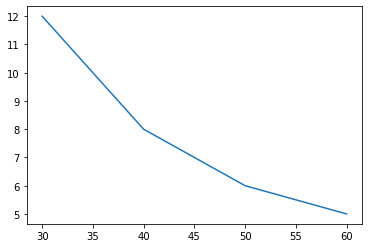

In [72]:
30-12
40-8
50-6
60-5
plt.plot([30,40,50,60],[12,8,6,5])
for freq in [30,40,50,60]:
    smpls2shift=round(900*pow(freq,-1.274))
    print(freq,smpls2shift)

2451 2451


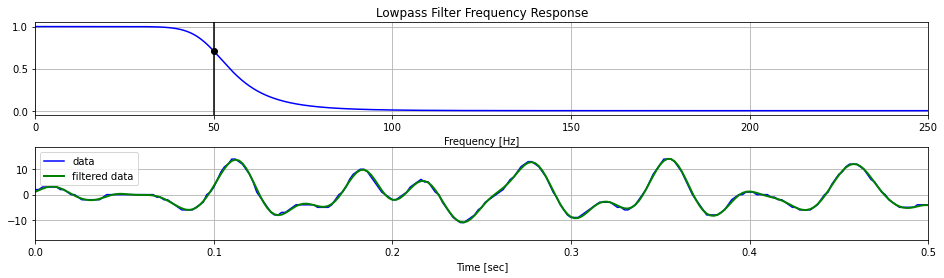

In [73]:


# Filter requirements.
order = 6
fs = 500.0       # sample rate, Hz
cutoff = 50.0  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.figure(figsize=(16,4))
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs);plt.title("Lowpass Filter Frequency Response");plt.xlabel('Frequency [Hz]');plt.grid();
dt=0.002
trc=x[2,:]
# trc=traces[10]
t = np.arange(0,  (len(trc)-1)*dt+dt,dt)
print(len(t),len(trc))
# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(trc, cutoff, fs, order)
plt.subplot(2, 1, 2)
plt.plot(t, trc, 'b-', label='data')
freq=cutoff
smpls2shift=round(900*pow(freq,-1.274))
fromsample=smpls2shift
# fromsample=5
plt.plot(t[:len(t)-fromsample], y[fromsample:], 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.xlim([0,0.5]);plt.grid();plt.legend();
plt.subplots_adjust(hspace=0.35)
plt.show()

In [119]:
# # trc.reshape((1,len(trc)))

# f = signal.resample(trc, len(trange))
# trange,f

freq peak: 14.89 Hz
freq peak: 14.89 Hz


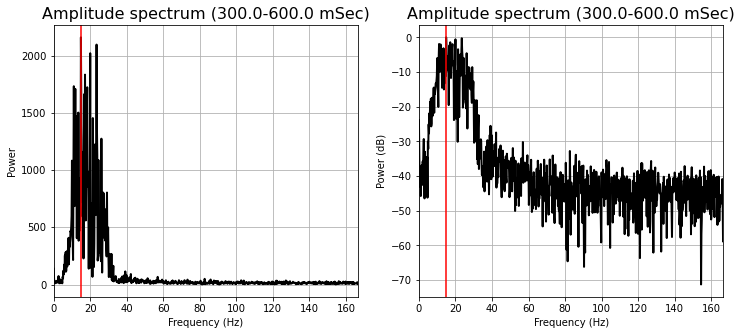

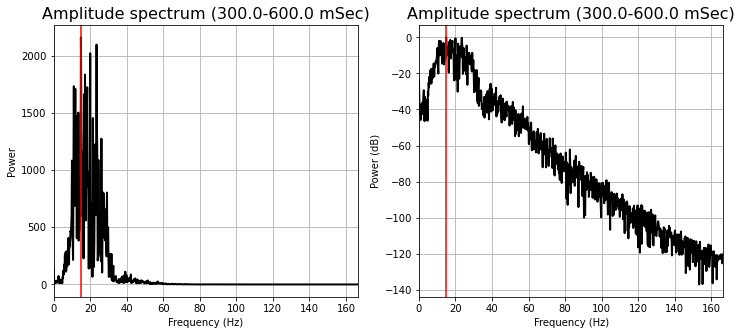

In [74]:
t[:4]
# plt.plot(x[2,:])
sr=2.0
freq,amp0,db0,f_peak=fullspec(trc.reshape((1,len(trc))),sr)
fimg_path=folder+"fsepc.png"
namestr="Amplitude spectrum ({}-{} mSec)".format(fromtime,tilltime)
plot_ampspec(freq,amp0,f_peak,name=namestr,img_fpath=fimg_path)

freq,amp0,db0,f_peak=fullspec(y.reshape((1,len(y))),sr)
fimg_path=folder+"fsepc.png"
namestr="Amplitude spectrum ({}-{} mSec)".format(fromtime,tilltime)
plot_ampspec(freq,amp0,f_peak,name=namestr,img_fpath=fimg_path)

In [362]:
# # f
# dt=f.samples[1]-f.samples[0]

# plt.plot(f.samples[:10],'.'),dt

# with segyio.open(path, "r", iline=1, xline=169, strict=True, ignore_geometry=False, endian='big') as f:
#     x = segyio.tools.collect(f.trace[:])
#     print(f.ilines)

# # plt.figure(figsize=(6,16))

# # plt.imshow(x.T, cmap=plt.cm.BuPu_r)
# spec = segyio.tools.metadata(f)
# spec.format

In [205]:
# f.ilines,f.xlines,
# f.samples, f.sorting,
# dir(f.format)
# f.format
# f.header
# dir(spec)
# spec.offsets
# spec.ilines,spec.xlines,spec.samples,spec.sorting,spec.format,spec.offsets

In [207]:
# header="""
# C 1 SEGY OUTPUT FROM Petrel 2021.1 Thursday, June 23 2022 10:53:13
# C 2 Name: bak_test Type: 2D seismic
# C 3
# C 4 First CDP: 1.000000 Last CDP: 169.000000
# C 5 First SP:  1.000000 Last SP:  169.000000
# C 6 CRS: <undef>
# C 7 X min: 266898.00 max: 268670.00 delta: 1772.00
# C 8 Y min: 2542424.00 max: 2544524.00 delta: 2100.00
# C 9 Time min: -1500.50 max: -1299.50 delta: 201.00
# C10 Lat min: - max: - delta: -
# C11 Long min: - max: - delta: -
# C12 Trace min: -1500.00 max: -1300.00 delta: 200.00
# C13 Seismic (template) min: ~1128.78 max: ~8406.86 delta: ~7278.08
# C14 Amplitude (data) min: ~1128.78 max: ~8406.86 delta: ~7278.08
# C15 Trace sample format: IEEE floating point
# C16 Coordinate scale factor: 1.00000
# C17
# C18 Binary header locations:
# C19 Sample interval             : bytes 17-18
# C20 Number of samples per trace : bytes 21-22
# C21 Trace date format           : bytes 25-26
# C22
# C23 Trace header locations:
# C24 Inline number               : bytes 5-8
# C25 SP Number                   : bytes 17-20
# C26 CDP number                  : bytes 21-24
# C27 Coordinate scale factor     : bytes 71-72
# C28 X coordinate                : bytes 73-76
# C29 Y coordinate                : bytes 77-80
# C30 Trace start time/depth      : bytes 109-110
# C31 Number of samples per trace : bytes 115-116
# C32 Sample interval             : bytes 117-118
# C33
# C34
# C35
# C36
# C37
# C38
# C39
# C40 END EBCDIC
# """
# # hs=header.split('\n')
# # for h in hs:    
# #     print('{}: "{}"'.format(h[1:3],h[3:]))

In [448]:

folder=r'.//'
# path=folder+'img.segy'
path='bak_test2.sgy'
import datetime 
mintime,mxtime,dt=1300,1500,1
# path='Seismic_data_to_be_digitized_bad_quality_23jun22.segy'
# path='Seismic_data_to_be_digitized_good_quality.segy'
f = segyio.open(path, iline=1, xline=169, strict=True, ignore_geometry=False, endian='big')
# x = segyio.tools.collect(f.trace[:])


# plt.figure(figsize=(6,16))

# plt.imshow(x.T, cmap=plt.cm.BuPu_r)
# # plt.show()


def default_text_header(iline, xline, offset,mypath):
    lines = {
        1: "DATE %s" % datetime.date.today().isoformat(),
        2: "Name: %10s Type: 2D seismic"%mypath,
        3: "For Bhugarbho ",
        4: "Image to segy conversion by Ameyem Geosolutions",
        5: "First CDP: 1.000000 Last CDP: %03d.000000" % xline,
        6: "First SP:  1.000000 Last SP:  %03d.000000" % xline,
        8: " Time min: %03d max: %03d delta: %03d" %(mintime,mxtime,dt),
        9: " Lat min: - max: - delta: -",
        10: " Long min: - max: - delta: -",        
        11: "TRACE HEADER POSITION:",
        12: "  INLINE BYTES %03d-%03d    | OFFSET BYTES %03d-%03d" % (iline, iline + 4, int(offset), int(offset) + 4),
        13: "  CROSSLINE BYTES %03d-%03d |" % (xline, xline + 4),
        
        15: " Trace sample format: IEEE floating point",
        16: " Coordinate scale factor: 1.00000",
        17: "",
        18: " Binary header locations:",
        19: " Sample interval             : bytes 17-18",
        20: " Number of samples per trace : bytes 21-22",
        21: " Trace date format           : bytes 25-26",
        22: "",
        23: " Trace header locations:",
        24: " Inline number               : bytes 5-8",
        25: " SP Number                   : bytes 17-20",
        26: " CDP number                  : bytes 21-24",
        27: " Coordinate scale factor     : bytes 71-72",
        28: " X coordinate                : bytes 73-76",
        29: " Y coordinate                : bytes 77-80",
        30: " Trace start time/depth      : bytes 109-110",
        31: " Number of samples per trace : bytes 115-116",
        32: " Sample interval             : bytes 117-118",        
        39: "END EBCDIC HEADER",
    }
    rows = segyio.create_text_header(lines)
    rows = bytearray(rows, 'ascii')  # mutable array of bytes
    rows[-1] = 128  # \x80 -- Unsure if this is really required...
    return bytes(rows)  # immutable array of bytes that is compatible with strings

In [459]:
xline

169

In [472]:
# orfilttrcs.shape
# filttrcs=orfilttrcs.copy()

In [450]:
orfilttrcs=filttrcs.copy()

In [477]:
#Resampling at 4ms
four_secfilttrcs= filttrcs[::2,:].copy()
print(four_secfilttrcs.shape)
filttrcs=four_secfilttrcs.copy()
filttrcs=filttrcs.astype(np.float64)
print(filttrcs.shape)

(1226, 408)
(1226, 408)


In [451]:
resfilttrcs= np.zeros((filttrcs.shape[0]*2,filttrcs.shape[1]))
print(resfilttrcs.shape)

resfilttrcs[::2,:]=filttrcs

# filttrcs.shape
for i in range(1,len(resfilttrcs[:,0])-1,2):
#     print(i)
#     if i==10: break
    resfilttrcs[i,:]=(resfilttrcs[i-1,:]+resfilttrcs[i+1,:])/2
filttrcs=resfilttrcs.copy()
filttrcs=filttrcs.astype(np.float64)

(4902, 408)
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
193
195
197
199
201
203
205
207
209
211
213
215
217
219
221
223
225
227
229
231
233
235
237
239
241
243
245
247
249
251
253
255
257
259
261
263
265
267
269
271
273
275
277
279
281
283
285
287
289
291
293
295
297
299
301
303
305
307
309
311
313
315
317
319
321
323
325
327
329
331
333
335
337
339
341
343
345
347
349
351
353
355
357
359
361
363
365
367
369
371
373
375
377
379
381
383
385
387
389
391
393
395
397
399
401
403
405
407
409
411
413
415
417
419
421
423
425
427
429
431
433
435
437
439
441
443
445
447
449
451
453
455
457
459
461
463
465
467
469
471
473
475
477
479
481
483
485
487
489
491
493
495
497
499
501
503
505
507
509
511
513
515
517
519
521

4791
4793
4795
4797
4799
4801
4803
4805
4807
4809
4811
4813
4815
4817
4819
4821
4823
4825
4827
4829
4831
4833
4835
4837
4839
4841
4843
4845
4847
4849
4851
4853
4855
4857
4859
4861
4863
4865
4867
4869
4871
4873
4875
4877
4879
4881
4883
4885
4887
4889
4891
4893
4895
4897
4899


In [475]:

# # len(resfilttrcs[:,0])
# resfilttrcs.shape
# config['position']['depth']['top'],config['position']['depth']['bottom']+1,filttrcs.shape[0]
# config['position']['depth']['top'],config['position']['depth']['bottom']

In [476]:
# # resfilttrcs[:10,:10]
# # resfilttrcs[-10:,-10:],orfilttrcs[-15:,-10:]
# # # plt.plot(resfilttrcs[:,-10:])
# spec
# spec.ilines
# # resfilttrcs.shape
# spec.samples.shape,filttrcs.shape[0]

In [478]:
# src.bin
# dir(TraceField)
# filttrcs=resfilttrcs.copy()
delrt=4
dstpath='my_custom_segy_{}ms.sgy'.format(delrt)
image_filepath,segy_filepath,config_filepath=convert(file)    

try:
    config = toml.load(config_filepath)
except toml.decoder.TomlDecodeError as e:
    raise ConfigurationError(f"Configuration error in {config_filepath}: {e}") from e
# config['position']['left']['x'],config['position']['right']['x'],config['position']['depth']


spec = segyio.tools.metadata(f)

spec.ilines=np.arange(1,filttrcs.shape[1]+1)
# spec.ilines
spec.samples = np.arange(config['position']['depth']['top'],config['position']['depth']['bottom']+2,delrt)
if len(spec.samples)!=filttrcs.shape[0]:
    print('.error()')
else:
    print('Reday to go')


def getmydict(i):
    return {TraceField.TRACE_SEQUENCE_LINE: i+1,
 TraceField.TraceNumber: i+1,
 TraceField.EnergySourcePoint: i+1,
 TraceField.CDP: i+1,
 TraceField.SourceX: 0,
 TraceField.SourceY: 0,
 TraceField.LagTimeA: 0,
 TraceField.DelayRecordingTime: 0,
 TraceField.TRACE_SAMPLE_COUNT: filttrcs.shape[0],
 TraceField.TRACE_SAMPLE_INTERVAL: delrt*1000,
 TraceField.CDP_X: 0,
 TraceField.CDP_Y: 0,
 TraceField.ShotPoint: i+1*100}

# spec.ilines  = [1, 2, 3, 4]
# spec.xlines  = [11, 12, 13]

# spec.sorting = 2
# spec.format  = 1
# with segyio.create(path, spec) as f:
#     ## fill the file with data
#      pass

srcpath='bak_test2.sgy'
# dstpath='my_custom_segy_1ms.sgy'


iline, xline, offset=0,169,0
rows=default_text_header(iline, xline, offset, dstpath)
theader=bytearray(rows)
mybin=[]
i=0
with segyio.open(srcpath, iline=1, xline=169, strict=True, ignore_geometry=False, endian='big') as src:
    with segyio.create(dstpath, spec) as dst:
        dst.text[0] = theader
        dst.header[i] = src.header[0]
        print(len(dst.header))
        for i,x in enumerate(dst.header[:]):
            x.update(getmydict(i))
#             x.update({ TraceField.offset: 1, 2484: 10 })
        
        dst.bin = src.bin
#         mybin= src.bin
        dst.bin.update({BinField.Interval:delrt*1000,BinField.Samples: filttrcs.shape[0]})
        print(dst.bin)
        dst.trace = list(filttrcs.T)

Reday to go
408
{JobID: 1, LineNumber: 1, ReelNumber: 1, Traces: 1, AuxTraces: 0, Interval: 4000, IntervalOriginal: 0, Samples: 1226, SamplesOriginal: 0, Format: 5, EnsembleFold: 1, SortingCode: 4, VerticalSum: 1, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 1, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}


(4902, 408)

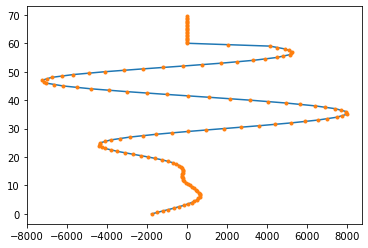

In [457]:
mlen=70
col=150
plt.plot(orfilttrcs[-mlen:,col],list(range(0,mlen,1)))
plt.plot(resfilttrcs[-mlen*2:,col],np.arange(0,mlen,0.5),'.')
# mybin
filttrcs.shape

In [443]:
resfilttrcs
# .shape

array([[-0.00579342,  1.99599863,  2.10838941, ...,  0.08396488,
         0.11782365,  0.08710391],
       [-0.00585496,  2.26310277,  2.3759044 , ...,  0.08546267,
         0.1197234 ,  0.08850037],
       [-0.0059165 ,  2.53020692,  2.6434194 , ...,  0.08696046,
         0.12162314,  0.08989684],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [364]:
# p=5
# mydict={}
# for k in f.header[p]:
#     if f.header[p][k]>1:
#         mydict[k]=f.header[p][k]
# #         print(k,f.header[p][k])
# # mheader
# # mheader
# print(mydict)
# mydict
# filttrcs.shape
# mfilttrcs=list(filttrcs.T)
# len(mfilttrcs[0])
# src.bin

In [365]:

# for k in mydict:
#     if k==TraceField.TRACE_SEQUENCE_LINE:
#         print(k)
# mydict

In [280]:
mheader[10] = { 37: 5, TraceField.INLINE_3D: 2484 }

In [366]:
# dst.trace = filttrcs.T
# len(f.header)
# f.header[100]

# >>> for x in header[:]:
# ...     x[37] = 1
# ...     x.update({ TraceField.offset: 1, 2484: 10 })

In [367]:

# folder=r'.//'
# # path=folder+'img.segy'
# path='img.segy'
# path='Seismic_data_to_be_digitized_bad_quality_23jun22.segy'
# # path='Seismic_data_to_be_digitized_good_quality.segy'
# src = segyio.open(path)
# x = segyio.tools.collect(f.trace[:])


# plt.figure(figsize=(6,16))

# plt.imshow(x.T, cmap=plt.cm.BuPu_r)
# # plt.show()